## **Step 1: Brief description of the problem and data (5 pts)**

**Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.**

The main purpose and task for this project is to build a machine learning model to classify tweets as either pertaining to a real disaster (1) or not (0). This is a binary classification problem in the domain of NLP, and it has real world implications for disaster response and news reporting.

The dataset is made of 10,000 tweets, split into training (train.csv) and testing (test.csv) sets located in the data folder. Each tweet entry features a unique identifier (id), the tweet's text (text), the location it was sent from (location, which may be blank), and a keyword (keyword, also potentially blank). For the training set, there's an additional target column indicating whether the tweet is about a real disaster (1) or not (0). This structured dataset forms the basis for your NLP model training and evaluation. Submissions are evaluated using F1 between the predicted and expected answers.

### **Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)**

**Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?**

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print(train_data.head(20))
print(train_data.info())

    id keyword location                                               text  \
0    1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1    4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2    5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3    6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4    7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
5    8     NaN      NaN  #RockyFire Update => California Hwy. 20 closed...   
6   10     NaN      NaN  #flood #disaster Heavy rain causes flash flood...   
7   13     NaN      NaN  I'm on top of the hill and I can see a fire in...   
8   14     NaN      NaN  There's an emergency evacuation happening now ...   
9   15     NaN      NaN  I'm afraid that the tornado is coming to our a...   
10  16     NaN      NaN        Three people died from the heat wave so far   
11  17     NaN      NaN  Haha South Tampa is getting flooded hah

The training dataset, contains 7,613 entries and it is structured with the following columns:

id: A unique identifier for each individual tweet.
keyword: This may feature a specific keyword from the tweet however, it's possible for this field to be blank.
location: Denotes the origin of the tweet but can sometimes be missing.
text: The actual content of the tweet.
target: The key outcome we need to predict whether a tweet relates to an actual disaster (1) or not (0).
For the data cleaning process, we must address a few challenges: the 'keyword' and 'location' fields often contain missing values, and the 'text' field may include a variety of noise. So with that said the next step will be to:

- Manage the absent data in the 'keyword' and 'location' fields.
- Analize the interaction and distribution of 'keywords', 'location', and 'text' in relation to the target variable.
- Improve the clarity and accuracy of the 'text' by removing or correcting noisy elements.

In [3]:
# Analyzing the percentage of missing values in 'keyword' and 'location' columns
missing_values = train_data[['keyword', 'location']].isnull().mean() * 100

# Applying the chosen strategies:
train_data['keyword'].fillna('no_keyword', inplace=True)
train_data['location'].fillna('unknown', inplace=True)

# Check to confirm the changes
updated_missing_values = train_data[['keyword', 'location']].isnull().mean() * 100

missing_values, updated_missing_values



(keyword      0.801261
 location    33.272035
 dtype: float64,
 keyword     0.0
 location    0.0
 dtype: float64)


Before handling the missing data, we can see that the keyword column had about 0.80% missing values, and the location column had approximately 33.27% missing values. So we have taken the following steps to address this:

- For keyword: Missing values were replaced with the placeholder 'no_keyword', considering the potential importance of keywords in understanding the context of tweets.
- For location: Given its less clear significance, missing values were replaced with 'unknown'. Another option could have been to drop this column, but retaining it with a placeholder allows for the possibility of exploring any patterns or insights the location data might offer.

After applying these strategies, there are now no missing values in both the keyword and location columns. This step makes the data more consistent and can help in more accurate modeling and analysis.

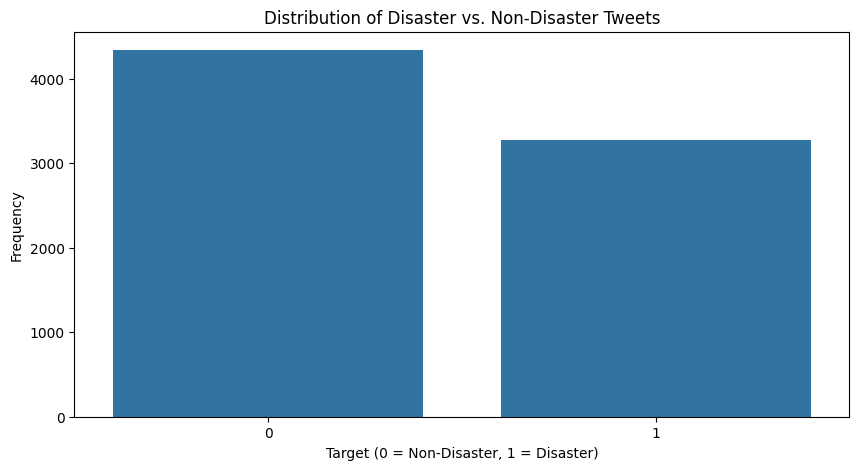

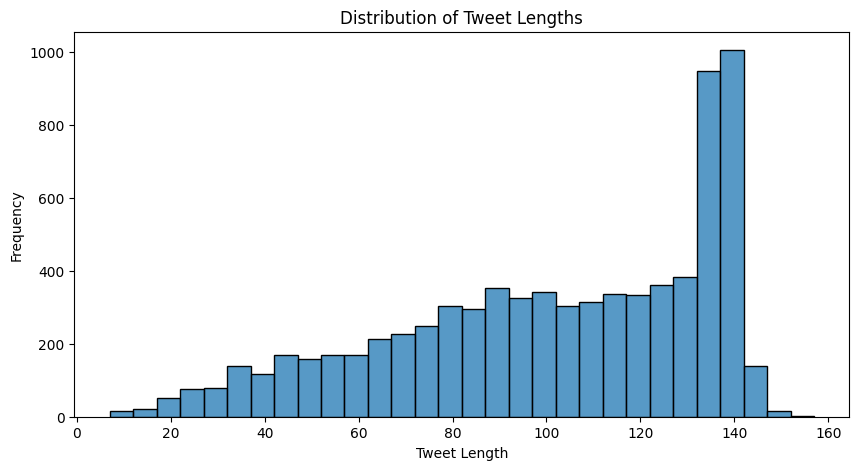

In [4]:
# Creating visualizations for a better understanding of the data

# Histogram for the distribution of target values (disaster vs. non-disaster)
plt.figure(figsize=(10, 5))
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Disaster vs. Non-Disaster Tweets')
plt.xlabel('Target (0 = Non-Disaster, 1 = Disaster)')
plt.ylabel('Frequency')
plt.show()

# Calculating tweet length
train_data['tweet_length'] = train_data['text'].apply(len)

# Histogram for tweet lengths
plt.figure(figsize=(10, 5))
sns.histplot(train_data['tweet_length'], bins=30, kde=False)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()


### **Distribution of Disaster vs. Non-Disaster Tweets:**
The count plot indicates a relatively balanced distribution between disaster (1) and non-disaster (0) tweets. This balance is beneficial for training a classification model, as it reduces the risk of bias towards a particular class.

### **Distribution of Tweet Lengths:**
The histogram shows a wide range of tweet lengths. Most tweets are concentrated around a certain length, but there's a considerable spread, indicating variability in how much text users use in their tweets.

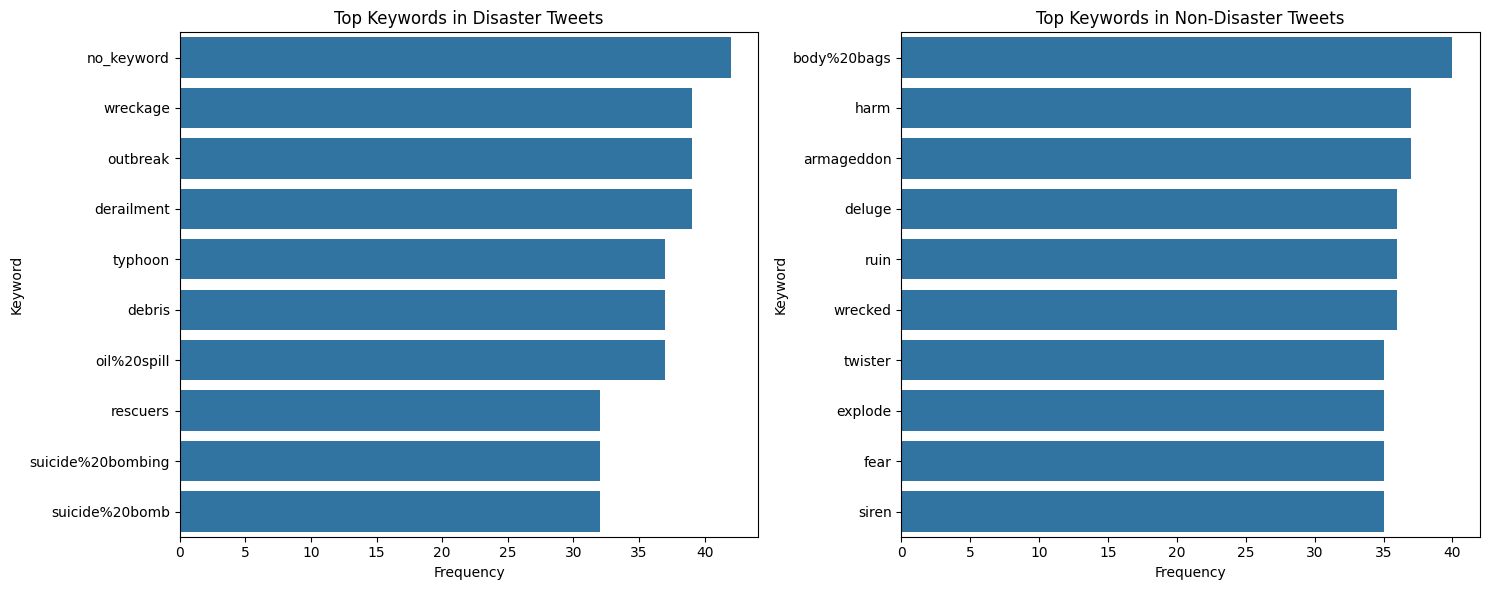

In [5]:
#Visualizations for top keywords and locations associated with disaster and non-disaster tweets

# Top keywords for disaster tweets
top_keywords_disaster = train_data[train_data['target'] == 1]['keyword'].value_counts().head(10)
top_keywords_non_disaster = train_data[train_data['target'] == 0]['keyword'].value_counts().head(10)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=top_keywords_disaster.values, y=top_keywords_disaster.index)
plt.title('Top Keywords in Disaster Tweets')
plt.xlabel('Frequency')
plt.ylabel('Keyword')

# Top keywords for non-disaster tweets
plt.subplot(1, 2, 2)
sns.barplot(x=top_keywords_non_disaster.values, y=top_keywords_non_disaster.index)
plt.title('Top Keywords in Non-Disaster Tweets')
plt.xlabel('Frequency')
plt.ylabel('Keyword')

plt.tight_layout()
plt.show()


The bar plots display the top keywords found in disaster and non disaster tweets. This visualization helps in understanding which keywords are most prevalent in each category and may indicate certain keywords that are strong predictors of a tweet's nature regarding real disasters.

As for the location data, due to its diverse nature and the large number of unique locations, deriving clear insights might be more challenging so we will avoid going that route for now.

Next, we will proceed with text-preprocessing for the text data as we saw that the data is very informal and noisy as seen earlier



### **Data Cleaning**

Text preprocessing is vital in natural language processing as it cleans and structures the text data, making it more suitable for analysis and modeling. Here are the key cleaning procedures we will target:
- **Lowercase Conversion:** Uniforms the text by converting all characters to lowercase.
- **Removing Emojis:** Strips emojis from the text to eliminate non textual elements.
- **Removing URLs and Mentions:** Clears website links and user mentions to focus on the core text content.
- **Removing Special Characters:** Eliminates punctuation and special symbols to reduce noise in the text.
- **Tokenization:** Breaks down the text into individual words or tokens for easier processing.
- **Removing Stopwords:** Filters out common but insignificant words like "the" and "is" to focus on relevant content.
- **Stemming/Lemmatization:** Simplifies words to their base form for consistency and reduced complexity.
- **Removing Digits:** Discards standalone numbers that don’t contribute to the text's meaning.
- **Removing Single Letters:** Eliminates solitary letters to reduce noise and focus on meaningful words.

In [6]:
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juanmarino/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juanmarino/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
def clean_text(text):
    # Lowercasing
    text = text.lower()

    # Removing Emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"  
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Removing URLs and Mentions
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)

    # Removing Special Characters and Digits
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\d', '', text)

    # Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    # Removing Stopwords and Single Letters
    stop_words = set(stopwords.words('english'))
    filtered_text = [word for word in tokens if word not in stop_words and len(word) > 1]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]

    return " ".join(lemmatized_text)

train_data['cleaned_text'] = train_data['text'].apply(clean_text)
train_data['cleaned_text']



0              deed reason earthquake may allah forgive u
1                   forest fire near la ronge sask canada
2       resident asked shelter place notified officer ...
3       people receive wildfire evacuation order calif...
4       got sent photo ruby alaska smoke wildfire pour...
                              ...                        
7608    two giant crane holding bridge collapse nearby...
7609    control wild fire california even northern par...
7610                                 utckm volcano hawaii
7611    police investigating ebike collided car little...
7612    latest home razed northern california wildfire...
Name: cleaned_text, Length: 7613, dtype: object

## **Step 3: Model Architecture (25 pts)**

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

### **Processing Text with TF-IDF**
TF-IDF, which stands for Term Frequency Inverse Document Frequency, is a widely used statistical measure in NLP to evaluate the importance of a word in a document, set within a group of documents. It's particularly useful for our project for indentifying distinctive words in tweets about real disasters versus non disaster ones.

**How TF-IDF Works:**

- Term Frequency (TF): This measures how frequently a term appears in a document. Simply put, it's the ratio of the number of times a word appears in a document compared to the total number of words in that document. The intuition is that the importance of a word is proportional to its frequency.
- Inverse Document Frequency (IDF): This measures the importance of a term across a set of documents. IDF decreases the weight for commonly used words and increases the weight for words that are not used in many documents. This helps to adjust for the fact that some words appear more frequently in general.
- TF-IDF Calculation: The TF-IDF value is obtained by multiplying TF and IDF. The higher the TF-IDF score, the rarer the term is in the given document set, and consequently, the more important it is.

**Why TF-IDF is Suitable for this Project:**

- Differentiating Key Words: For classifying tweets, TF-IDF can effectively highlight words that are uniquely significant in disaster related tweets as opposed to those in everyday conversations.
- Handling Text Data: Since machine learning models work better with numerical data, converting text to a numerical format using TF-IDF is beneficial. This conversion helps identifying and scoring the words that are most relevant to the classification task.
- Versatility: It's adaptable for various machine learning models, including Naive Bayes and Support Vector Machines, and enhances the outcomes compared to basic word count methods.

Resources: https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/, https://www.learndatasci.com/glossary/tf-idf-term-frequency-inverse-document-frequency/

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample data (list of preprocessed tweets)
preprocessed_tweets = train_data['cleaned_text']

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

# Fit and Transform the Text Data
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_tweets)


## **LSTM Architecture**

**Why do we use LSTM:**
LSTMs are particularly suited for handling sequential data like text, making them ideal for analyzing tweets. They excel in maintaining context over long sequences, which is vital for distinguishing between literal and metaphorical language in tweets. Specifically engineered to overcome the vanishing gradient problem seen in traditional RNNs, LSTMs can remember information over extended sequences, aiding in accurately classifying tweets with nuanced meanings. Their flexibility allows for adjustments in layers and neurons to cater to the specific complexities of natural language processing tasks. In addition to this, LSTMs are robust against the informal language, abbreviations, and non standard grammar typically found in social media content, enhancing their effectiveness in processing tweets.

Resources: https://colah.github.io/posts/2015-08-Understanding-LSTMs/, http://web.stanford.edu/class/cs224n/


### **Model 1 Architecture**

- Input Reshaping: Neural networks, especially LSTMs, require data in a specific format. Reshaping the data ensures compatibility with the LSTM layers, allowing the model to accurately process the sequential nature of text.

- LSTM Layers: These layers are the core of the model, chosen for their ability to capture and remember information over sequences of text. This is essential in understanding the context and nuances in tweets, which is crucial for accurate classification.

- Dropout Layers: They help in reducing overfitting, which is a common problem in deep learning models. By randomly deactivating neurons, the model becomes more robust and generalized.

- Dense Layers: Before making a final prediction, it's helpful to have dense layers to process the information derived from LSTM layers. These layers essentially learn to interpret the features extracted by the LSTMs.

- Output Layer with Sigmoid Activation: The use of a sigmoid activation function in the final layer is ideal for binary classification problems. It squashes the output to a range between 0 and 1, providing a probabilistic interpretation of the two classes (disaster or not).

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_tweets)
train_sequences = tokenizer.texts_to_sequences(train_data['cleaned_text'])

vocabulary_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

max_length = max(len(seq) for seq in train_sequences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')


In [12]:
tfidf_matrix_dense = tfidf_matrix.todense()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from tensorflow.keras.layers import Embedding

model = Sequential()
model.add(Embedding(vocabulary_size, 50, input_length=max_length))
model.add(LSTM(units=50, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))  # First LSTM layer
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))  # Second LSTM layer
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
train_labels = train_data['target'].values

model.fit(train_padded, train_labels, epochs=5, batch_size=64, validation_split=0.2)



Epoch 1/5
96/96 [==============================] - 4s 22ms/step - loss: 0.5941 - accuracy: 0.6668 - val_loss: 0.4949 - val_accuracy: 0.7564
Epoch 2/5
96/96 [==============================] - 2s 21ms/step - loss: 0.3396 - accuracy: 0.8591 - val_loss: 0.4688 - val_accuracy: 0.7873
Epoch 3/5
96/96 [==============================] - 2s 21ms/step - loss: 0.2244 - accuracy: 0.9189 - val_loss: 0.5322 - val_accuracy: 0.7584
Epoch 4/5
96/96 [==============================] - 2s 21ms/step - loss: 0.1588 - accuracy: 0.9456 - val_loss: 0.5646 - val_accuracy: 0.7485
Epoch 5/5
96/96 [==============================] - 2s 22ms/step - loss: 0.1261 - accuracy: 0.9575 - val_loss: 0.7524 - val_accuracy: 0.7406


In [14]:
tfidf_matrix_dense = tfidf_matrix.todense()
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
embedding_dim = 100  # or any other size you want for the word embeddings

model2 = Sequential()
model2.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_length))
model2.add(Bidirectional(LSTM(units=50, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model2.add(Dropout(0.3))
model2.add(Bidirectional(LSTM(50)))
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model2.fit(train_padded, train_labels, epochs=5, batch_size=64, validation_split=0.2)




Epoch 1/5
96/96 [==============================] - 7s 46ms/step - loss: 0.5656 - accuracy: 0.7018 - val_loss: 0.6591 - val_accuracy: 0.6881
Epoch 2/5
96/96 [==============================] - 5s 50ms/step - loss: 0.3041 - accuracy: 0.8778 - val_loss: 0.5967 - val_accuracy: 0.7715
Epoch 3/5
96/96 [==============================] - 5s 48ms/step - loss: 0.1883 - accuracy: 0.9335 - val_loss: 0.5329 - val_accuracy: 0.7466
Epoch 4/5
96/96 [==============================] - 5s 50ms/step - loss: 0.1364 - accuracy: 0.9527 - val_loss: 0.5443 - val_accuracy: 0.7209
Epoch 5/5
96/96 [==============================] - 5s 50ms/step - loss: 0.1058 - accuracy: 0.9642 - val_loss: 0.6351 - val_accuracy: 0.7183
